In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# PyMC3 for Bayesian Inference
import pymc3 as pm

This code run in the Kaggle notebook environment for checking the Bayesian linear regression, which is based on CARLOS SOUZA.

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Kaggle_ML/OSIC/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Kaggle_ML/OSIC/test.csv")

In [4]:
#label encoder for patientid
le_id = LabelEncoder()
df_train['PatientID'] = le_id.fit_transform(df_train['Patient'])

# the log value of FVC is more approporiate in this case
df_train['FVC_base'] = df_train['FVC']
df_train['FVC'] = np.log(df_train['FVC'])

df_train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID,FVC_base
0,ID00007637202177411956430,-4,7.747165,58.253649,79,Male,Ex-smoker,0,2315
1,ID00007637202177411956430,5,7.702556,55.712129,79,Male,Ex-smoker,0,2214
2,ID00007637202177411956430,7,7.630947,51.862104,79,Male,Ex-smoker,0,2061
3,ID00007637202177411956430,9,7.670429,53.950679,79,Male,Ex-smoker,0,2144
4,ID00007637202177411956430,11,7.634821,52.063412,79,Male,Ex-smoker,0,2069


In [5]:
#One-Hot encode for category features:sex and smokingstatus
COLS = ['Sex','SmokingStatus']
for col in COLS:
    for mod in df_train[col].unique():
        df_train[mod] = (df_train[col] == mod).astype(int)

In [6]:
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID,FVC_base,Male,Female,Ex-smoker,Never smoked,Currently smokes
0,ID00007637202177411956430,-4,7.747165,58.253649,79,Male,Ex-smoker,0,2315,1,0,1,0,0
1,ID00007637202177411956430,5,7.702556,55.712129,79,Male,Ex-smoker,0,2214,1,0,1,0,0
2,ID00007637202177411956430,7,7.630947,51.862104,79,Male,Ex-smoker,0,2061,1,0,1,0,0
3,ID00007637202177411956430,9,7.670429,53.950679,79,Male,Ex-smoker,0,2144,1,0,1,0,0
4,ID00007637202177411956430,11,7.634821,52.063412,79,Male,Ex-smoker,0,2069,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,7.905442,66.594637,73,Male,Never smoked,175,2712,1,0,0,1,0
1545,ID00426637202313170790466,19,7.999007,73.126412,73,Male,Never smoked,175,2978,1,0,0,1,0
1546,ID00426637202313170790466,31,7.975221,71.407524,73,Male,Never smoked,175,2908,1,0,0,1,0
1547,ID00426637202313170790466,43,7.997999,73.052745,73,Male,Never smoked,175,2975,1,0,0,1,0


In [7]:
df1 = df_train[['Patient', 'Weeks', 'Percent']].sort_values(by=['Patient', 'Weeks'])
df1 = df_train.groupby('Patient').head(1)
df1 = df1.rename(columns={'Percent': 'Percent_base'})
df_train = pd.merge(df_train, df1[['Patient', 'Percent_base']], how='left',on='Patient')
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID,FVC_base,Male,Female,Ex-smoker,Never smoked,Currently smokes,Percent_base
0,ID00007637202177411956430,-4,7.747165,58.253649,79,Male,Ex-smoker,0,2315,1,0,1,0,0,58.253649
1,ID00007637202177411956430,5,7.702556,55.712129,79,Male,Ex-smoker,0,2214,1,0,1,0,0,58.253649
2,ID00007637202177411956430,7,7.630947,51.862104,79,Male,Ex-smoker,0,2061,1,0,1,0,0,58.253649
3,ID00007637202177411956430,9,7.670429,53.950679,79,Male,Ex-smoker,0,2144,1,0,1,0,0,58.253649
4,ID00007637202177411956430,11,7.634821,52.063412,79,Male,Ex-smoker,0,2069,1,0,1,0,0,58.253649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,7.905442,66.594637,73,Male,Never smoked,175,2712,1,0,0,1,0,71.824968
1545,ID00426637202313170790466,19,7.999007,73.126412,73,Male,Never smoked,175,2978,1,0,0,1,0,71.824968
1546,ID00426637202313170790466,31,7.975221,71.407524,73,Male,Never smoked,175,2908,1,0,0,1,0,71.824968
1547,ID00426637202313170790466,43,7.997999,73.052745,73,Male,Never smoked,175,2975,1,0,0,1,0,71.824968


Our model can be describes as:
$$
FVC_{ij} \sim \mathcal{N}(\alpha_i + X_{ij} \beta_i, \sigma)
$$

Reference: Carlos Souza's Bayesian notebook

​
$X_{ij}$ is a vector of the patient *i* at timestep *j* :Male ;Ex-smoker;Currently-smokes;Percent from patient *i* at baseline moment;The week 


prior distributions for the parameters

Firstly, I try simple model, then extend to more data

In [8]:
num_patients =df_train['Patient'].nunique()
FVC_obs = df_train['FVC'].values
Weeks = df_train['Weeks'].values
PatientID = df_train['PatientID'].values

In [9]:
with pm.Model() as model_base:
    # create shared variables 
    FVC_obs_shared = pm.Data("FVC_obs_shared", FVC_obs)
    Weeks_shared = pm.Data('Weeks_shared', Weeks)
    PatientID_shared = pm.Data('PatientID_shared', PatientID)
    
    mu_a = pm.Normal('mu_a', mu=1700., sigma=400)
    sigma_a = pm.HalfNormal('sigma_a', 1000.)
    mu_b = pm.Normal('mu_b', mu=-4., sigma=1)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=num_patients)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=num_patients)

    # Model error
    sigma = pm.HalfNormal('sigma', 150.)

    FVC_est = a[PatientID_shared] + b[PatientID_shared] * Weeks_shared

    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu=FVC_est,
                         sigma=sigma, observed=FVC_obs_shared)
    
    # Fitting the model
    trace_base = pm.sample(1500, tune=2000, target_accept=.9, init="adapt_diag",return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 1_500 draw iterations (4_000 + 3_000 draws total) took 352 seconds.


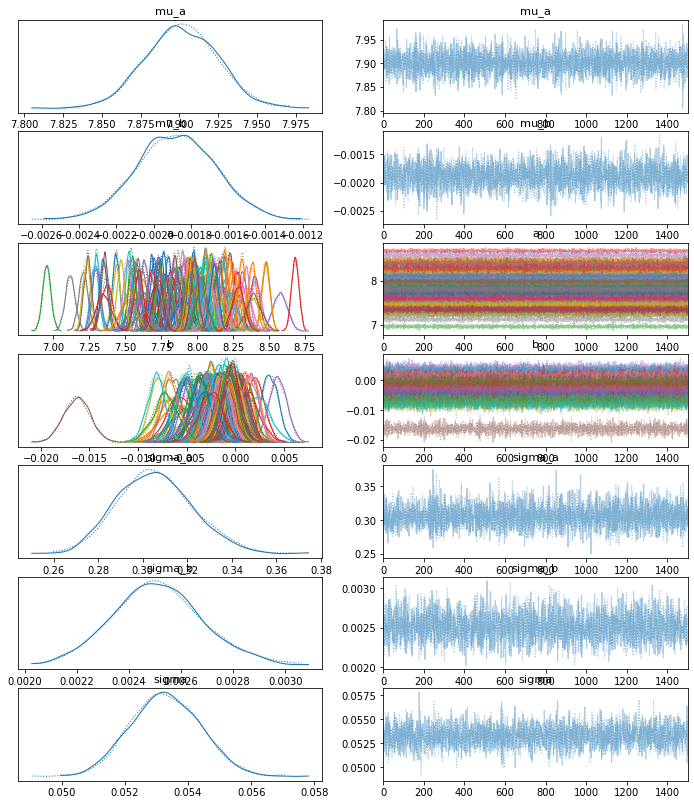

In [10]:
with model_base:
    pm.plot_trace(trace_base);

In [11]:
pred_df = []
for i in range(df_train['Patient'].nunique()):
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['PatientID'] = i
    pred_df.append(df)
pred_df = pd.concat(pred_df, ignore_index=True)
pred_df

,PatientID,Weeks
0,0,-12
1,0,-11
2,0,-10
3,0,-9
4,0,-8
...,...,...
25691,175,129
25692,175,130
25693,175,131
25694,175,132


In [12]:
with model_base:
    pm.set_data({
        "PatientID_shared": pred_df['PatientID'].values.astype(int),
        "Weeks_shared": pred_df['Weeks'].values.astype(int),
        "FVC_obs_shared": np.zeros(len(pred_df)).astype(int),
    })
    posterior_pred = pm.sample_posterior_predictive(trace_base)

In [13]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_pred', 'sigma'])
df['Patient'] = le_id.inverse_transform(pred_df['PatientID'])
df['Weeks'] = pred_df['Weeks']
df['FVC_pred'] = posterior_pred['FVC_like'].T.mean(axis=1)
df['sigma'] = posterior_pred['FVC_like'].T.std(axis=1)
df

,Patient,Weeks,FVC_pred,sigma
0,ID00007637202177411956430,-12,7.702912,0.062716
1,ID00007637202177411956430,-11,7.703267,0.063504
2,ID00007637202177411956430,-10,7.702533,0.061348
3,ID00007637202177411956430,-9,7.700313,0.060493
4,ID00007637202177411956430,-8,7.699124,0.061251
...,...,...,...,...
25691,ID00426637202313170790466,129,7.910566,0.113973
25692,ID00426637202313170790466,130,7.907792,0.114303
25693,ID00426637202313170790466,131,7.908604,0.114418
25694,ID00426637202313170790466,132,7.907929,0.114243


In [14]:
original_train = pd.read_csv("/content/drive/MyDrive/Kaggle_ML/OSIC/train.csv")
df = pd.merge(df, original_train[['Patient', 'Weeks', 'FVC']], how='left', on=['Patient', 'Weeks'])
df= df.dropna()

In [15]:
df

,Patient,Weeks,FVC_pred,sigma,FVC
8,ID00007637202177411956430,-4,7.693318,0.059477,2315.0
17,ID00007637202177411956430,5,7.679686,0.056549,2214.0
19,ID00007637202177411956430,7,7.675378,0.057978,2061.0
21,ID00007637202177411956430,9,7.672380,0.056312,2144.0
23,ID00007637202177411956430,11,7.668674,0.056775,2069.0
...,...,...,...,...,...
25582,ID00426637202313170790466,13,7.974734,0.056235,2712.0
25588,ID00426637202313170790466,19,7.972283,0.056374,2978.0
25600,ID00426637202313170790466,31,7.965153,0.056732,2908.0
25612,ID00426637202313170790466,43,7.957045,0.058963,2975.0


In [16]:
#Calculate Laplace Log Likelihood
sigma_c = df['sigma'].values
sigma_c[sigma_c < 70] = 70
delta = (df['FVC_pred'] - df['FVC']).abs()
delta[delta > 1000] = 1000
Metrics = - np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f'Laplace Log Likelihood: {Metrics.mean():.4f}')

Laplace Log Likelihood: -24.7853
